(1000, 40, 216, 1)
1000
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.1222 - loss: 2.3451 - val_accuracy: 0.0938 - val_loss: 2.2991
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.2006 - loss: 2.2688 - val_accuracy: 0.2313 - val_loss: 2.2168
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.2385 - loss: 2.1816 - val_accuracy: 0.2500 - val_loss: 2.1357
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.3218 - loss: 1.9914 - val_accuracy: 0.3125 - val_loss: 1.9584
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.4452 - loss: 1.7424 - val_accuracy: 0.3750 - val_loss: 1.8632
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.4636 - loss: 1.6102 - val_accuracy: 0.3438 - val_loss: 1.7958
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5748 - loss: 1.3272 - val_accuracy: 0.4250 - val_loss: 1.6989
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.5852 - loss: 

'\n    训练准确率大于验证准确率,有过拟合现象发生,训练轮数越多,准确率逐步提升。\n    提升准确率的方向:\n    1)将音乐数据分段,每一段视为一组数据,使用pydub库调用AudioSegment.from_wav()载入文件,即可切割。\n    2)数据增补(Data Augmentation):将音乐存储为png文件,再利用ImageDataGenerator类别进行数据增补,产生更多的数据\n'

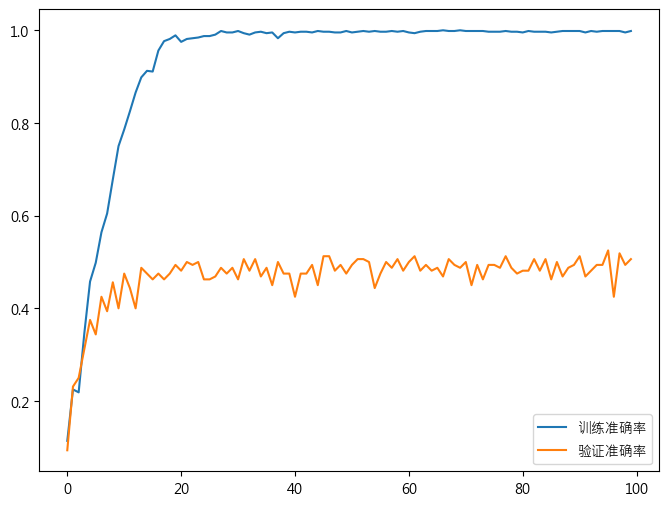

In [10]:
import time

import matplotlib.pyplot as plt

'''
    音乐曲风分类
    数据集
    http://marsyas.info/downloads/datasets.html
    http://opihi.cs.uvic.ca/sound/genres.tar.gz

    修复文件问题: ffmpeg.exe -i jazz.00000.wav -c:a pcm_s16le jazz_fixed.00054.wav
'''
import numpy as np
import librosa.display
import os
import pathlib
import tensorflow as tf
from sklearn.model_selection import train_test_split

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
#1.加载音频文件
X = None
y = []
for i,g in enumerate(genres):
    pathlib.Path(f'E:/develop/AI/AI数据集/gtzan_data_set/archive/Data/genres_original/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'E:/develop/AI/AI数据集/gtzan_data_set/archive/Data/genres_original/{g}'):
        songname = f'E:/develop/AI/AI数据集/gtzan_data_set/archive/Data/genres_original/{g}/{filename}'

        data,sr = librosa.load(songname,mono=True,duration=5)
        mfcc = librosa.feature.mfcc(y=data,sr=sr,n_mfcc=40)

        # 计算时间维度
        time_steps = mfcc.shape[1]  # mfcc 的形状是 (n_mfcc, time_steps)，例如 (40, time_steps)
        if X is None:
            X = mfcc.reshape(1,40,time_steps,1)
        else:
            X = np.concatenate((X, mfcc.reshape(1,40,time_steps,1)), axis=0)
        y.append(i)

print(X.shape) # 1000个音频文件,梅尔频倒谱系数40维,时间维度time_steps,1个通道
print(len(y))

# 2.特征缩放,数据正态化
X_norm = (X - X.min(axis=0)) /(X.max(axis=0) - X.min(axis=0))

# 3. 将数据切割为训练数据和测试数据
y = np.array(y)  # 确保 y 是 numpy 数组
if X_norm is None or len(y) == 0:
    raise ValueError("X_norm or y is empty or not properly defined")
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

#4.CNN模型
input_shape = X_train.shape[1:]
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape = input_shape),
        tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ]
)

# model = tf.keras.Sequential([
#     tf.keras.Input(shape=input_shape),
#     tf.keras.layers.Conv2D(32,kernel_size=(3,3),strides=(2,2),activation='relu'),
#     tf.keras.layers.AveragePooling2D(pool_size=(2,2)),
#     tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides=(2,2),activation='relu'),
#     tf.keras.layers.AveragePooling2D(pool_size=(2,2)),
#     tf.keras.layers.Conv2D(128,kernel_size=(3,3),padding='same'),
#     tf.keras.layers.AveragePooling2D(pool_size=(2,2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(64,activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(10,activation='softmax')
# ])
#模型构建方式2

# 5.模型训练、评分
##5.1设定优化器、损失函数、效果衡量指标
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

##5.2模型训练
history = model.fit(X_train,y_train,epochs=100,validation_split=0.2)

##5.3评分
score = model.evaluate(X_test,y_test,verbose=0)

for i,x in enumerate(score):
    print(f'{model.metrics_names[i]}:{score[i]:.4f}')

##6.训练过程的绘图
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus']=False

plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'],label='训练准确率')
plt.plot(history.history['val_accuracy'],label='验证准确率')
plt.legend()

'''
    训练准确率大于验证准确率,有过拟合现象发生,训练轮数越多,准确率逐步提升。
    提升准确率的方向:
    1)将音乐数据分段,每一段视为一组数据,使用pydub库调用AudioSegment.from_wav()载入文件,即可切割。
    2)数据增补(Data Augmentation):将音乐存储为png文件,再利用ImageDataGenerator类别进行数据增补,产生更多的数据
'''

(1000, 40, 108, 1)
1000
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.0910 - loss: 2.3243 - val_accuracy: 0.1562 - val_loss: 2.2980
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.1562 - loss: 2.2917 - val_accuracy: 0.1688 - val_loss: 2.2753
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.2043 - loss: 2.2420 - val_accuracy: 0.2062 - val_loss: 2.1837
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.2845 - loss: 2.0408 - val_accuracy: 0.3125 - val_loss: 2.0436
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4163 - loss: 1.8365 - val_accuracy: 0.3438 - val_loss: 1.8022
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4550 - loss: 1.6309 - val_accuracy: 0.3875 - val_loss: 1.7429
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5372 - loss: 1.4053 - val_accuracy: 0.3688 - val_loss: 1.6493
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5594 - loss: 1.3087 - 

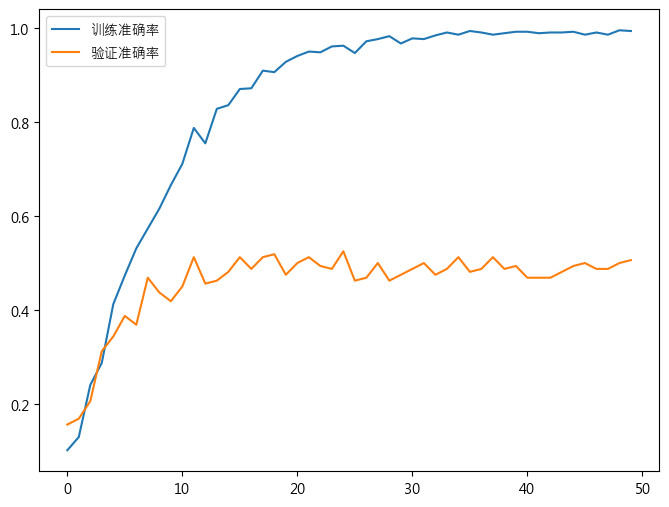

In [9]:
import matplotlib.pyplot as plt

'''
   优化版本一,将音乐数据分段
'''
import numpy as np
import librosa.display
import os
import pathlib
import tensorflow as tf
from sklearn.model_selection import train_test_split

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
#1.加载音频文件
X = None
y = []
for i,g in enumerate(genres):
    pathlib.Path(f'E:/develop/AI/AI数据集/gtzan_data_set/archive/Data/genres_original/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'E:/develop/AI/AI数据集/gtzan_data_set/archive/Data/genres_original/{g}'):
        songname = f'E:/develop/AI/AI数据集/gtzan_data_set/archive/Data/genres_original/{g}/{filename}'
        data,sr = librosa.load(songname,mono=True,duration=25)

        try:
            if i == 0:
                segment_length = int(data.shape[0] / 10)
            for j in range(10):
                segment = data[j * segment_length:(j + 1) * segment_length]
                mfcc = librosa.feature.mfcc(y=segment,sr=sr,n_mfcc=40)
                  # 计算时间维度
                time_steps = mfcc.shape[1]  # mfcc 的形状是 (n_mfcc, time_steps)，例如 (40, time_steps)
            if X is None:
                X = mfcc.reshape(1,40,time_steps,1)
            else:
                X = np.concatenate((X, mfcc.reshape(1,40,time_steps,1)), axis=0)
            y.append(i)
        except:
            print(i)
            raise Exception('')
print(X.shape) # 1000个音频文件,梅尔频倒谱系数40维,时间维度time_steps,1个通道
print(len(y))

# 2.特征缩放,数据正态化
X_norm = (X - X.min(axis=0)) /(X.max(axis=0) - X.min(axis=0))

# 3. 将数据切割为训练数据和测试数据
y = np.array(y)  # 确保 y 是 numpy 数组
if X_norm is None or len(y) == 0:
    raise ValueError("X_norm or y is empty or not properly defined")
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

#4.CNN模型
input_shape = X_train.shape[1:]
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape = input_shape),
        tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ]
)

# model = tf.keras.Sequential([
#     tf.keras.Input(shape=input_shape),
#     tf.keras.layers.Conv2D(32,kernel_size=(3,3),strides=(2,2),activation='relu'),
#     tf.keras.layers.AveragePooling2D(pool_size=(2,2)),
#     tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides=(2,2),activation='relu'),
#     tf.keras.layers.AveragePooling2D(pool_size=(2,2)),
#     tf.keras.layers.Conv2D(128,kernel_size=(3,3),padding='same'),
#     tf.keras.layers.AveragePooling2D(pool_size=(2,2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(64,activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(10,activation='softmax')
# ])
#模型构建方式2

# 5.模型训练、评分
##5.1设定优化器、损失函数、效果衡量指标
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

##5.2模型训练
history = model.fit(X_train,y_train,epochs=50,validation_split=0.2)

##5.3评分
score = model.evaluate(X_test,y_test,verbose=0)

for i,x in enumerate(score):
    print(f'{model.metrics_names[i]}:{score[i]:.4f}')

##6.训练过程的绘图
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus']=False

plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'],label='训练准确率')
plt.plot(history.history['val_accuracy'],label='验证准确率')
plt.legend()


(19757,)
(22050,)
(22050,)


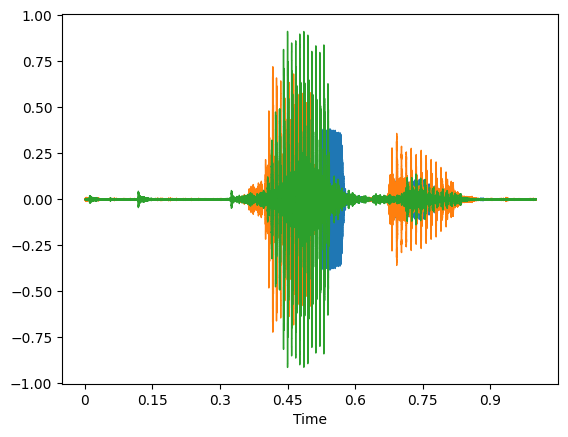

In [14]:
'''
    短指令辨识,一样使用MFCC变量,导入CNN模型,即可进行分类。
    数据集: https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.01.tar.gz
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import pathlib
import csv
import tensorflow as tf

#1.文件测试
path = 'E:/develop/AI/AI数据集/speech_commands_v0.01/happy/'

##文件1的波形
data, sr = librosa.load(path+'0ab3b47d_nohash_0.wav')
librosa.display.waveshow(data, sr=sr)  # 修改为 waveshow
print(data.shape)

##文件2的波形
data, sr = librosa.load(path+'0f7205ef_nohash_1.wav')
librosa.display.waveshow(data, sr=sr)
print(data.shape)

##文件3的波形
data, sr = librosa.load(path+'0bd689d7_nohash_1.wav')
librosa.display.waveshow(data, sr=sr)
print(data.shape)

#2.播放文件
from IPython.display import Audio
Audio(data,rate=sr)

#3.获取音频